In [ ]:
!pip install pvlib
!apt install swig cmake 
!pip install stable-baselines3[extra] box2d box2d-kengz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 224 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (2,917 kB/s)
Selecting previously uns

## Download the folder "BEAR" and upload it to your Drive in "My Drive", then run the cells

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/BEAR/Models")

Mounted at /content/gdrive


In [ ]:
from building_HVAC import BuildingEnvReal
from MPC_Controller import MPCAgent
from bldg_utils import ParameterGenerator
import numpy as np
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt

**In this example, we use a customized model outside of the GEAR given models. The following building is selected from the EnergyPlus example files. We try to develop it in our building model generator and compare the simulation results.**

We start by creating an environment:

In [ ]:
numofhours=24*(4)
chicago=[20.4,20.4,20.4,20.4,21.5,22.7,22.9,23,23,21.9,20.7,20.5]
city='chicago'
filename='Exercise2A-mytestTable.html'
weatherfile='USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw'
U_Wall=[2.811,12.894,0.408,0.282,1.533,12.894,1.493]
Parameter=ParameterGenerator(filename,weatherfile,city,U_Wall=U_Wall,Ground_Tp=chicago,shgc=0.568,AC_map=np.array([1,1,1,1,1,0])
                            ,shgc_weight=0.1,ground_weight=0.7,full_occ=np.array([1,2,3,4,5,0]),
                            reward_gamma=[0.1,0.9],activity_sch=np.ones(100000000)*1*117.24) #Description of ParameterGenerator in bldg_utils.py
env = BuildingEnvReal(Parameter)

###############All Zones from Ground############
SOUTH PERIMETER  [Zone index]:  0
EAST PERIMETER  [Zone index]:  1
NORTH PERIMETER  [Zone index]:  2
WEST PERIMETER  [Zone index]:  3
CORE  [Zone index]:  4
PLENUM  [Zone index]:  5
###################################################


In [ ]:
obs_dim = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(obs_dim))
action_dim = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(action_dim))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  10
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


We use a MPC controller to set the indoor temperature at $22^\circ$C with a daily operating schedule of 8 a.m. to 3 p.m.

In [ ]:
agent = MPCAgent(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset()
schedule=np.concatenate([np.ones(7)*0,np.ones(7)*1,np.ones(10)*0])
for i in range(numofhours):
    a,s = agent.predict(env)
    if schedule[i%24]==0:
      a=a*0
    # print('lala',np.sum(a)*400)
    obs, r, done, _ = env.step(a)

MPCstate=env.statelist
MPCaction=env.actionlist

Reset [ 22.          22.          22.          22.          22.
  22.         -12.2          0.          20.4         -0.07901756]


For comparison, we also get Energyplus state and action under the same control logic:

In [ ]:
import pandas as pd
all=pd.read_csv('Exercise2A-mytest.csv')
# all=pd.read_csv('Exercise2A-all22.csv')  
# all=pd.read_csv('Exercise2A-1822.csv')  
pltemp=all['PLENUM:Zone Air Temperature [C](Hourly)']
southheat = all['SOUTH PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
southcool=all['SOUTH PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
southtemp=all['SOUTH PERIMETER:Zone Air Temperature [C](Hourly)']
eastheat = all['EAST PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
eastcool=all['EAST PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
easttemp=all['EAST PERIMETER:Zone Air Temperature [C](Hourly)']
northheat = all['NORTH PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
northcool=all['NORTH PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
northtemp=all['NORTH PERIMETER:Zone Air Temperature [C](Hourly)']
westheat = all['WEST PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
westcool=all['WEST PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
westtemp=all['WEST PERIMETER:Zone Air Temperature [C](Hourly)']
coreheat = all['CORE:Zone Air System Sensible Heating Rate [W](Hourly)']
corecool=all['CORE:Zone Air System Sensible Cooling Rate [W](Hourly)']
coretemp=all['CORE:Zone Air Temperature [C](Hourly)']
whole=all['Whole Building:Facility Total HVAC Electricity Demand Rate [W](Hourly)']
outtemp=all['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)']

EP_totalpower=southheat[:numofhours]+eastheat[:numofhours]+northheat[:numofhours]+westheat[:numofhours]+coreheat[:numofhours]+southcool[:numofhours]+eastcool[:numofhours]+northcool[:numofhours]+westcool[:numofhours]+corecool[:numofhours]
EP_state=[southtemp[:numofhours],easttemp[:numofhours],northtemp[:numofhours],westtemp[:numofhours],coretemp[:numofhours],pltemp[:numofhours]]


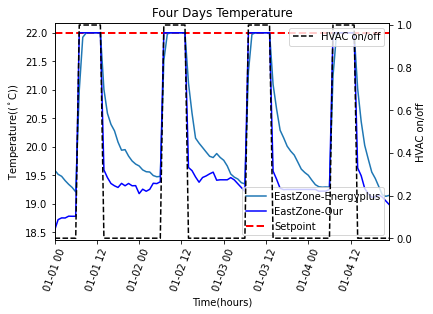

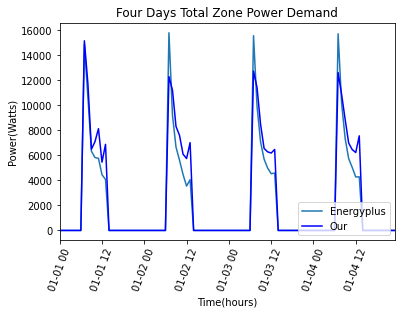

In [ ]:
dates = [datetime.datetime(2018, 1, 1) + datetime.timedelta(hours=k * 1)
        for k in range(24*4)]
fig, ax1 = plt.subplots() 
#################  PLOT A###################################
ax1.plot(dates,EP_state[4])
ax1.plot(dates,np.array(MPCstate)[:,4],color = 'blue')

ax1.hlines(y=22, xmin=dates[0], xmax=dates[-1], colors='red', linestyles='--', lw=2, label='Multiple Lines')
ax1.set_title('Four Days Temperature')
ax1.set_xlabel('Time(hours)')
ax1.set_ylabel('Temperature(($^\circ$C))')
ax1.legend(['EastZone-Energyplus','EastZone-Our','Setpoint'],loc='lower right')
ax1.set_xlim([dates[0], dates[-1]])
plt.xticks(rotation=70)
data2=np.concatenate([schedule,schedule,schedule,schedule])
ax2 = ax1.twinx() 
ax2.plot(dates, data2,'--', color = 'black')  
ax2.set_ylim([-0.01, 1.01])
ax2.legend(['HVAC on/off'])
plt.ylabel('HVAC on/off') 
plt.show()
################################################################

# EP_totalpower=whole[:numofhours]
MPC_totalpower=np.sum(np.abs(np.array(MPCaction)),1)
####################   PLOT B #############################
plt.plot(dates,EP_totalpower)
plt.plot(dates,MPC_totalpower,color = 'blue')

plt.xticks(rotation=70)
plt.title('Four Days Total Zone Power Demand')
plt.xlabel('Time(hours)')
plt.ylabel('Power(Watts)')
plt.legend(['Energyplus','Our'],loc='lower right')
plt.xlim([dates[0], dates[-1]])
plt.show()

In [ ]:
env.close()